In [3]:
import numpy as np
from anytree import Node, RenderTree

In [67]:
class LazyBranchAndBound:
    def __init__(self, A, k, initial_guess):
        # Validate inputs
        if not isinstance(k, int) or not isinstance(A, np.ndarray):
            raise ValueError("k must be an integer and A must be a numpy array")
        
        n = A.shape[0]
        if k > n:
            raise ValueError("k must be less than n")
        
        if A.shape[0] != A.shape[1]:
            raise ValueError("A must be a square matrix")
        
        if not np.all(A >= 0):
            raise ValueError("A must contain only non-negative values")
        
        if not np.allclose(A, A.T):
            raise ValueError("A must be symmetric")
        
        if not isinstance(initial_guess, (int, float)) or initial_guess < 0:
            raise ValueError("initial_guess must be a non-negative number")
        
        self.A = A
        self.k = k
        self.n = n
        self.best_guess = (initial_guess, [])
        self.root = Node(("root", 0, []), bound=float('inf'))

    def get_address(self, node):
        if node.is_root:
            return []
        return [node.name[0]] + node.parent.name[2] #Addresses are written in reverse to go from n down to 1.

    def _bound(self, node):
        """
        Computes the upper bound for a given node.
        For now, it returns +infinity as a dummy upper bound.

        :param node: The node for which to compute the upper bound.
        :return: The computed upper bound.
        """
        
        address = node.name[2]
        l = len(address)
        bound = 0
        #Term 1
        Al = self.A[:self.n-l+1, :self.n-l+1] #Accounting for 0-indexing
        bound += np.sum(Al)*self.k*0.5
        "Part of this term is cancelled out by the last part of Term 3."
        
        #Term 2
        for s in range(1,self.n-l):
            for t in range(self.k):
                for r in range(l):
                    bound += self.A[s][r+self.n-l] * np.exp(2*np.pi / self.k * t*address[r])

        #This term needs to be much more efficiently implemented. There might be some cancellation with the different t and r.
        #Term 3
        b3x = self.k*np.sum(self.A)*0.5
        # Convert address to a NumPy array
        address_array = np.array(address)

        # Create the Del matrix using broadcasting
        Del = (address_array[:, None] == address_array[None, :]).astype(int)
        b3y = (-1)*np.sum(np.multiply(Del,self.A[self.n-l:,self.n-l:,]))
        b3z = (-1)*0.5*np.sum(self.A[:self.n-l,:self.n-l]) #This looks like term 1 a lot, let's cancel out.
        b3 = b3x+b3y+b3z
        if b3 < 0:
            print(b3)
        bound += abs(b3)
        bound *= 0.5*(1/self.k)
        return bound
    
    def _branch(self, node):
        # Create k children nodes
        if len (node.name[2]) == self.n:
            return #Was creating excess nodes earlier, this is a temporary fix.
        for i in range(self.k):
            address = [i] + self.get_address(node)
            if len(address) > self.n:
                print(address)
            child = Node((i, node.depth, address), parent=node) #Remove node.depth, also it should be node.depth+1.
            child.bound = self._bound(child)

    def value(self, node):
        # Check if the node is an nth child of the root
        if node.depth != self.n:
            raise ValueError("_value cannot be called on a set")
        
        # Use the address directly
        z = node.name[2]
        
        result = 0
        for i in range(self.n):
            for j in range(i+1,self.n):
                if z[i] != z[j]:
                    result += self.A[i][j]
        
        return result

    def _prune(self, node):
        # Recursively delete all children
        for child in node.children:
            self._prune(child)
        # Detach the node from its parent and delete it
        node.parent = None
        del node
    """
    def _prune_ancestors(self, node): # This is not working as intended, trying to prune ancestors if they have no remaining children to save on memory.
        parent = node.parent
        while parent and not parent.is_root and len(parent.children) == 0:
            grandparent = parent.parent
            parent.parent = None
            del parent
            parent = grandparent
    """
    def search(self):
        stack = [self.root]
        best_guess_node = None
        
        while stack: #While stack is not empty
            node = stack.pop()
            
            if node.depth < self.n:
                if node.bound >= self.best_guess[0]:
                    self._branch(node)
                    for child in node.children:
                        stack.append(child)
                else:
                    # Prune the node and its children
                    self._prune(node)
                    
            else:
                value = self.value(node)
                if value > self.best_guess[0]:
                    self.best_guess = (value, node.name[2])
                    print("Best guess:", self.best_guess)
                    
                    # Remove the old best_guess node from the stack and the tree
                    if best_guess_node:
                        if best_guess_node in stack:
                            stack.remove(best_guess_node)
                        self._prune(best_guess_node)
                    
                    # Update the best_guess_node
                    best_guess_node = node

                    # Add all siblings of the current node to the stack
                    if not node.is_root:
                        for sibling in node.parent.children:
                            if sibling != node:
                                stack.append(sibling)

                elif value < self.best_guess[0]:
                    
                    """
                    #Check all siblings first for pruning purposes.
                    if not node.is_root:
                        for sibling in node.parent.children:
                            if sibling != node:
                                value = self.value(sibling)
                                if value > self.best_guess[0]:
                                    self.best_guess = (value, sibling.name[2])
                                    print("Best guess:", self.best_guess)
                                    
                                    # Remove the old best_guess node from the stack and the tree
                                    if best_guess_node:
                                        if best_guess_node in stack:
                                            stack.remove(best_guess_node)
                                        self._prune(best_guess_node)
                                    
                                    # Update the best_guess_node
                                    best_guess_node = sibling 

                                    
                    # Backtrack and prune ancestors if they have no remaining children
                    self._prune_ancestors(node)
                    """

                    # Prune the node if its value is less than the current best guess
                    self._prune(node)

In [51]:
# Test case
A = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])
k = 2
initial_guess = 0

bb = LazyBranchAndBound(A, k, initial_guess)
bb.search()

# Render the tree, showing only the address component of each node
for pre, fill, node in RenderTree(bb.root):
    print("%s%s" % (pre, node.name[2]))

3.0
3.0
4.0
2.0
2.0
0.0
Best guess: (1, [0, 1, 1])
2.0
4.0
Best guess: (2, [1, 0, 1])
2.0
4.0
[]
├── [0]
└── [1]
    ├── [0, 1]
    │   └── [1, 0, 1]
    └── [1, 1]


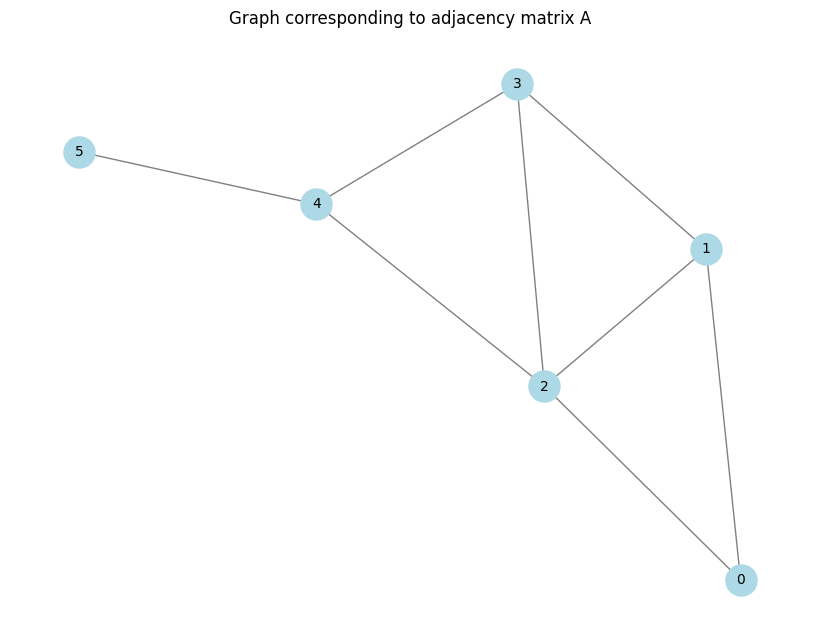

Best guess: (2, [0, 1, 1, 1, 1, 1])
Best guess: (3, [1, 0, 1, 1, 1, 1])
Best guess: (4, [1, 1, 0, 1, 1, 1])
Best guess: (6, [1, 0, 1, 1, 0, 1])
 [] inf
├──  [0] 6.75
│   ├──  [0, 0] 6.75
│   │   ├──  [0, 0, 0] 6.25
│   │   │   └──  [1, 0, 0, 0] 10.79
│   │   └──  [1, 0, 0] 17.82
│   │       ├──  [0, 1, 0, 0] 10.79
│   │       └──  [1, 1, 0, 0] 16.32
│   └──  [1, 0] 18.32
│       ├──  [0, 1, 0] 12.79
│       │   └──  [1, 0, 1, 0] 11.29
│       └──  [1, 1, 0] 23.36
│           ├──  [0, 1, 1, 0] 11.29
│           └──  [1, 1, 1, 0] 15.82
└──  [1] 12.29
    ├──  [0, 1] 7.25
    │   ├──  [0, 0, 1] 6.75
    │   │   └──  [1, 0, 0, 1] 11.29
    │   └──  [1, 0, 1] 18.32
    │       ├──  [0, 1, 0, 1] 11.29
    │       └──  [1, 1, 0, 1] 16.82
    │           └──  [0, 1, 1, 0, 1] 4.0
    │               ├──  [0, 0, 1, 1, 0, 1] 3.0
    │               └──  [1, 0, 1, 1, 0, 1] 3.0
    └──  [1, 1] 17.82
        ├──  [0, 1, 1] 12.29
        │   ├──  [0, 0, 1, 1] 5.25
        │   └──  [1, 0, 1, 1] 10.79


In [71]:
import networkx as nx

# Test case
import matplotlib.pyplot as plt
A = np.array([
    [0, 1, 1, 0, 0, 0],
    [1, 0, 1, 1, 0, 0],
    [1, 1, 0, 1, 1, 0],
    [0, 1, 1, 0, 1, 0],
    [0, 0, 1, 1, 0, 1],
    [0, 0, 0, 0, 1, 0]
])


# Create a graph from the adjacency matrix
G = nx.from_numpy_array(A)

# Draw the graph
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
plt.title("Graph corresponding to adjacency matrix A")
plt.show()
k = 2
initial_guess = 0

bb = LazyBranchAndBound(A, k, initial_guess)
bb.search()

# Render the tree, showing only the address component of each node
count = 0
for pre, fill, node in RenderTree(bb.root):
    count += 1
    print(f'{pre} {node.name[2]} {round(node.bound,2)}')
print(str(count / (bb.k**bb.n) * 100) + "% of the nodes were pruned.")